## Importing the necessary libraries

In [1]:
## Import the modules

import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io, img_as_float
import tifffile as tiff
from natsort import natsorted
import scipy as sp
import time
import scipy.io as sio
from skimage.registration import phase_cross_correlation
from scipy.ndimage import binary_erosion, binary_dilation
from skimage.exposure import match_histograms
from skimage.morphology import white_tophat, black_tophat, disk, rectangle
from skimage import measure, morphology
from skimage.measure import label, regionprops
from skimage.exposure import equalize_adapthist, is_low_contrast
from skimage.filters import threshold_otsu, threshold_local, threshold_niblack 
import hdf5storage
import warnings
warnings.filterwarnings("ignore")
import paramiko
warnings.filterwarnings(action='ignore',module='.*paramiko.*')



## Python function for processing filepaths in Windows

In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


## Define the largest connected components and erosion function

In [3]:
def get_largest_components(binary_mask, n=1, m=1):
    """
    Extract the n-th to m-th largest connected components from a binary mask.
    
    Parameters:
    binary_mask (numpy array): Binary mask with connected components.
    n (int): The starting index (1-based) for selecting components.
    m (int): The ending index (inclusive) for selecting components.

    Returns:
    numpy array: Binary mask with the selected components.
    """
    # Label connected components
    labeled_mask, num_features = label(binary_mask, return_num=True, connectivity=2)
    
    # Extract properties of labeled regions
    properties = regionprops(labeled_mask)
    
    # Sort regions by area (size) in descending order
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    
    # Create an empty mask for the selected components
    largest_components_mask = np.zeros_like(binary_mask)
    
    # Iterate over the n-th to m-th largest regions and add them to the mask
    for i in range(n-1, min(m, len(sorted_regions))):
        largest_components_mask[labeled_mask == sorted_regions[i].label] = 1
    
    return largest_components_mask
    

def apply_opening(binary_mask, n, structure=None):
    """
    Apply n iterations of binary opening on the binary mask.
    
    Opening consists of an erosion followed by a dilation.
    
    Parameters:
    binary_mask (numpy array): Binary mask to be processed.
    n (int): Number of erosion and dilation steps.
    structure (numpy array, optional): Structuring element for the operations.
                                       If None, a default cross-shaped element is used.
    
    Returns:
    numpy array: Binary mask after applying opening (erosion + dilation).
    """
    # Step 1: Apply n erosions
    eroded_mask = binary_mask.copy()
    for _ in range(n):
        eroded_mask = binary_erosion(eroded_mask, structure=structure)
    
    # Step 2: Apply n dilations to the eroded mask
    opened_mask = eroded_mask.copy()
    for _ in range(n):
        opened_mask = binary_dilation(opened_mask, structure=structure)
    
    return opened_mask


## Loading the image stack (jitter and bleach corrected)

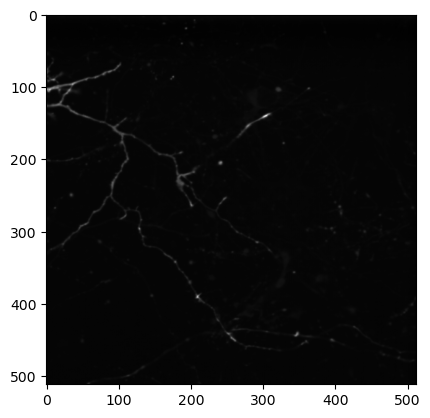

In [197]:
# Load the TIFF stack

data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFP_RFP 5_5 DIV7 488_561 timelapse1_C1');
file_name = 'GFP_RFP 5_5 DIV7 488_561 timelapse1_C1_jttr_blch_corr'
stack = tiff.imread(data_folder+'\\'+file_name+'.tiff') 

mean_frame = np.mean(stack,0)
mean_frame = mean_frame/np.max(mean_frame)    # normalizing the intensities of the mean-frame
plt.imshow(mean_frame, cmap='gray')   # check out the mean frame


In [198]:
# Check if the mean-frame has low contrast
is_low_contrast(mean_frame, fraction_threshold=0.05, lower_percentile=1, upper_percentile=99, method='linear')

True

## Use 3-step filtering on the mean time-frame or not
### i) CLAHE 
### ii) White top-hat  
### iii) Adaptive thresholding

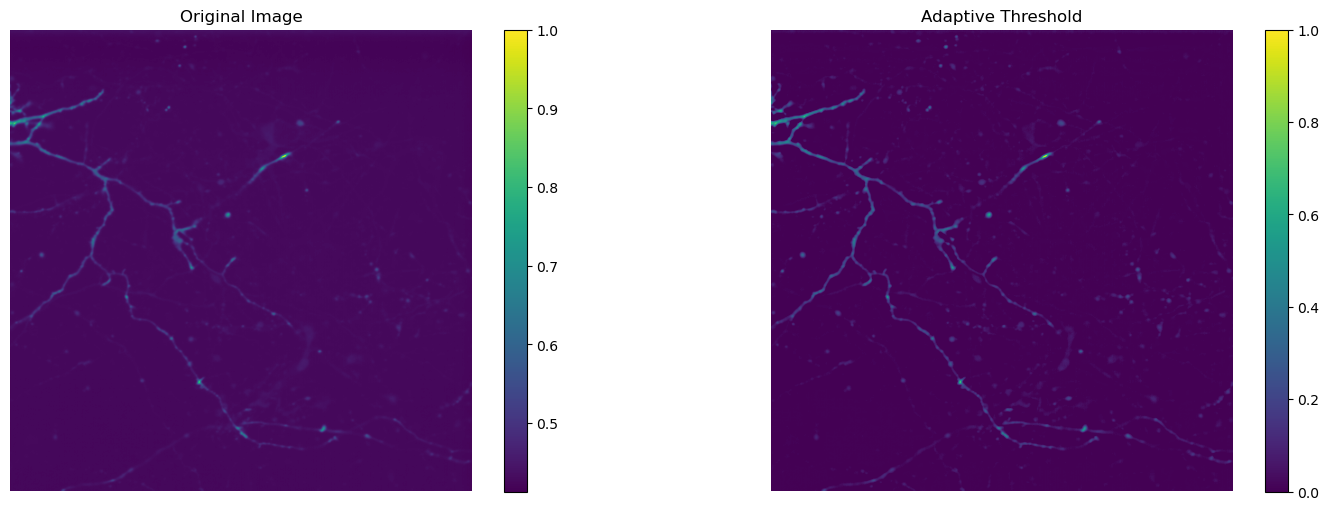

In [199]:
# value of 'yes' implements the 3-step filtering. Value 'no' takes the raw mean-frame.
do_filtering = 'yes'   
# do_filtering = 'no'

if do_filtering == 'yes':

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe_corrected = equalize_adapthist(mean_frame, clip_limit=0.01)
    
    # Apply the white tophat filter with the structuring element
    str_elem = disk(radius=15)  # Create a ball-shaped structuring element
    corrected_tphat = white_tophat(clahe_corrected, str_elem)
    
    # Apply adaptive (local) thresholding
    block_size = 35
    adaptive_thresh = threshold_niblack(corrected_tphat, window_size=15, k=0.2)
    
    adapt_corrected = corrected_tphat - adaptive_thresh  # Subtract the background estimated by adaptive thresholding
    adapt_corrected[adapt_corrected < 0] = 0    # Clip any negative values to zero

    binary_mask = adapt_corrected/adapt_corrected.max()>1e-2
    
    # Display the results
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(mean_frame); plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Adaptive Threshold')
    plt.imshow(adapt_corrected/adapt_corrected.max()); plt.colorbar()
    plt.axis('off')
    
    plt.show()

## Visualize and save the Binary Mask

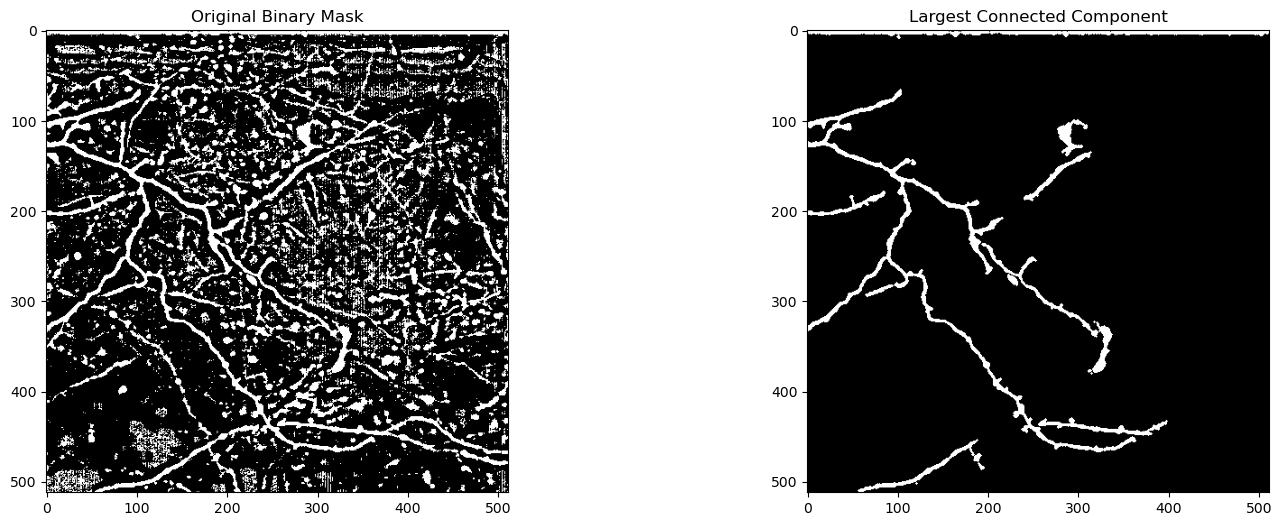

In [204]:
if do_filtering == 'yes':
    binary_mask = (adapt_corrected/adapt_corrected.max()) > 0.0055
else:
    binary_mask =  mean_frame > np.mean(mean_frame) + 0.001

do_opening = 'yes'   # value of '1' implements morphological opening

if do_opening == 'yes':
    n_opening_steps = 1 # Number of erosion steps
    eroded_mask = apply_opening(binary_mask, n_opening_steps)  # Apply n erosion steps
    
    # Get the largest m-th to n-th connected components
    largest_components = get_largest_components(eroded_mask, 1, 8)
else:
    largest_components = get_largest_components(binary_mask, 1, 4)


# Display the original, largest component, and skeletonized images
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].imshow(binary_mask, cmap='gray')
ax[0].set_title('Original Binary Mask')

ax[1].imshow(largest_components, cmap='gray')
ax[1].set_title('Largest Connected Component')

plt.show()
# sio.savemat(data_folder+'\\cell_mask.mat',{'binary_mask':largest_components},do_compression=False) # to save as .MAT files


### Further Processing of the mask (might not be necessary)

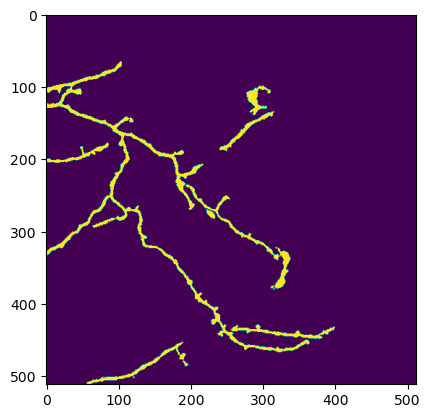

In [205]:
mask = largest_components
mask[0:15,:] = 0
mask = get_largest_components(mask, 1, 8)
# mask[0:100,0:100] = 0
plt.imshow(mask)
sio.savemat(data_folder+'\\cell_mask.mat',{'binary_mask':mask},do_compression=False) # to save as .MAT files